In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [106]:
# Load dataset
df = pd.read_csv('data/ai4i2020.csv')

# Drop columns that cause data leakage or are not useful
df_model = df.drop(columns=['UDI', 'Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])

# One-Hot Encoding for equipment type
df_model = pd.get_dummies(df_model, columns=['Type'], drop_first=True)

In [107]:
from sklearn.model_selection import train_test_split

# Features and target
X = df_model.drop('Machine failure', axis=1)
y = df_model['Machine failure']

# Train-test split (stratified due to class imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [108]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [109]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

model.fit(X_train_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [110]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred = model.predict(X_test_scaled)

# Classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1932
           1       0.14      0.82      0.24        68

    accuracy                           0.82      2000
   macro avg       0.57      0.82      0.57      2000
weighted avg       0.96      0.82      0.88      2000



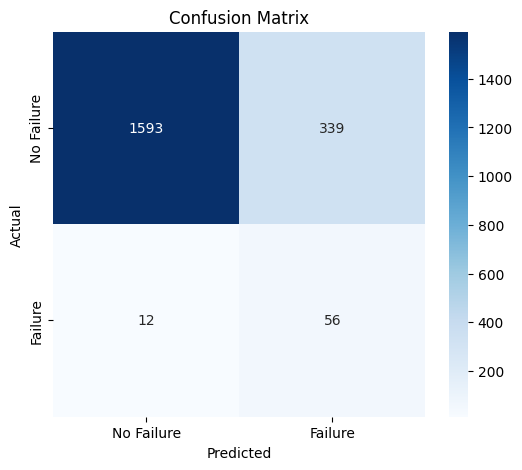

In [111]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['No Failure', 'Failure'],
    yticklabels=['No Failure', 'Failure']
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [112]:
# Select only failed machines
failed_data = df[df['Machine failure'] == 1]

# Use Tool wear as a proxy for Time-to-Failure
time_to_failure = failed_data['Tool wear [min]']

print(f"Number of failure samples: {len(time_to_failure)}")


Number of failure samples: 339


In [113]:
from scipy.stats import weibull_min

In [114]:
# Fit Weibull distribution (location fixed at 0)
shape, loc, scale = weibull_min.fit(time_to_failure, floc=0)

print(f"Shape (β): {shape:.2f}")
print(f"Scale (η): {scale:.2f}")


Shape (β): 1.95
Scale (η): 160.81


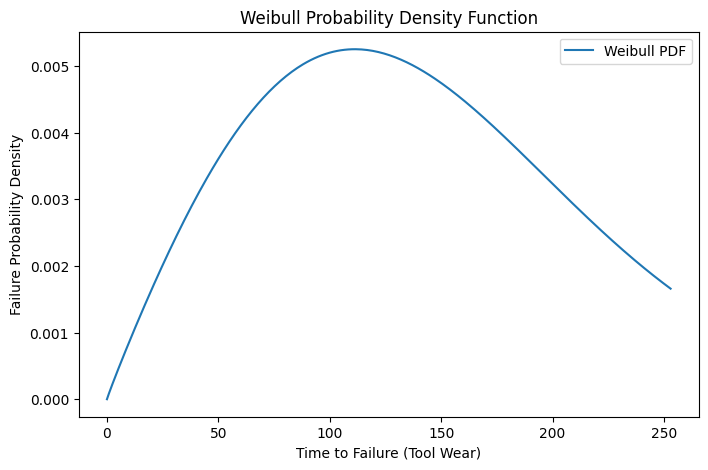

In [115]:
# Generate values for plotting
x = np.linspace(0, time_to_failure.max(), 300)

# Probability Density Function
pdf = weibull_min.pdf(x, shape, loc, scale)

plt.figure(figsize=(8, 5))
plt.plot(x, pdf, label='Weibull PDF')
plt.xlabel('Time to Failure (Tool Wear)')
plt.ylabel('Failure Probability Density')
plt.title('Weibull Probability Density Function')
plt.legend()
plt.show()


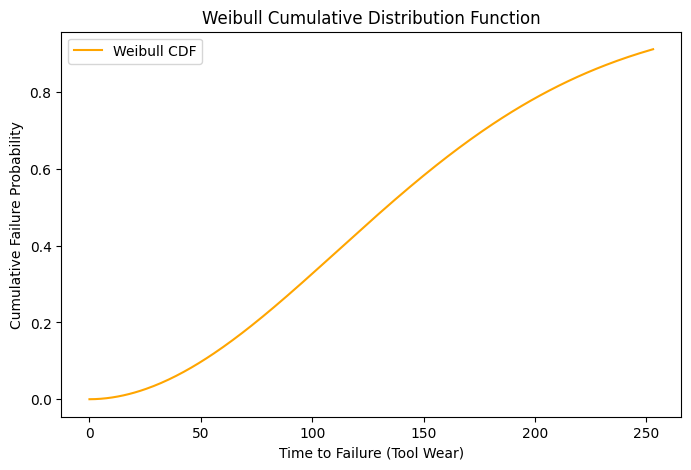

In [116]:
# Cumulative Distribution Function
cdf = weibull_min.cdf(x, shape, loc, scale)

plt.figure(figsize=(8, 5))
plt.plot(x, cdf, color='orange', label='Weibull CDF')
plt.xlabel('Time to Failure (Tool Wear)')
plt.ylabel('Cumulative Failure Probability')
plt.title('Weibull Cumulative Distribution Function')
plt.legend()
plt.show()


# Class Imbalance Analysis

In [117]:
# Check class distribution
print("Class Distribution:")
print(y_train.value_counts())
print(f"\nClass Ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")
print(f"\nFailure Rate: {y_train.value_counts()[1] / len(y_train) * 100:.2f}%")

Class Distribution:
Machine failure
0    7729
1     271
Name: count, dtype: int64

Class Ratio: 28.52:1

Failure Rate: 3.39%


# 🔄 Improved Model with SMOTE + Advanced ML Algorithms

## Problem Analysis:
- **Current Precision for Failure: 14%** (Too many false positives)
- **Class Imbalance: 28.5:1** (Only 3.39% failures)
- **Solution**: SMOTE + Random Forest + Feature Engineering

In [118]:
# Feature Engineering - Add interaction features
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

# Create interaction features
X_train_fe['Temp_Diff'] = X_train_fe['Process temperature [K]'] - X_train_fe['Air temperature [K]']
X_test_fe['Temp_Diff'] = X_test_fe['Process temperature [K]'] - X_test_fe['Air temperature [K]']

X_train_fe['Power'] = X_train_fe['Torque [Nm]'] * X_train_fe['Rotational speed [rpm]'] / 9550  # Power in kW
X_test_fe['Power'] = X_test_fe['Torque [Nm]'] * X_test_fe['Rotational speed [rpm]'] / 9550

X_train_fe['Torque_Tool_Interaction'] = X_train_fe['Torque [Nm]'] * X_train_fe['Tool wear [min]']
X_test_fe['Torque_Tool_Interaction'] = X_test_fe['Torque [Nm]'] * X_test_fe['Tool wear [min]']

print("✅ Feature Engineering Done")
print(f"New Features Shape: {X_train_fe.shape}")

✅ Feature Engineering Done
New Features Shape: (8000, 10)


In [119]:
# Scale the features
scaler_fe = StandardScaler()
X_train_scaled_fe = scaler_fe.fit_transform(X_train_fe)
X_test_scaled_fe = scaler_fe.transform(X_test_fe)

print("✅ Scaling Done")

✅ Scaling Done


In [120]:
# Apply SMOTE to balance the classes
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled_fe, y_train)

print("✅ SMOTE Applied")
print(f"Original Class Distribution: {y_train.value_counts().to_dict()}")
print(f"Balanced Class Distribution: {pd.Series(y_train_balanced).value_counts().to_dict()}")

✅ SMOTE Applied
Original Class Distribution: {0: 7729, 1: 271}
Balanced Class Distribution: {0: 7729, 1: 7729}


In [121]:
# Train Random Forest Model
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_balanced, y_train_balanced)
print("✅ Random Forest Model Trained")

✅ Random Forest Model Trained


🌲 RANDOM FOREST RESULTS
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1932
           1       0.54      0.85      0.66        68

    accuracy                           0.97      2000
   macro avg       0.77      0.91      0.82      2000
weighted avg       0.98      0.97      0.97      2000



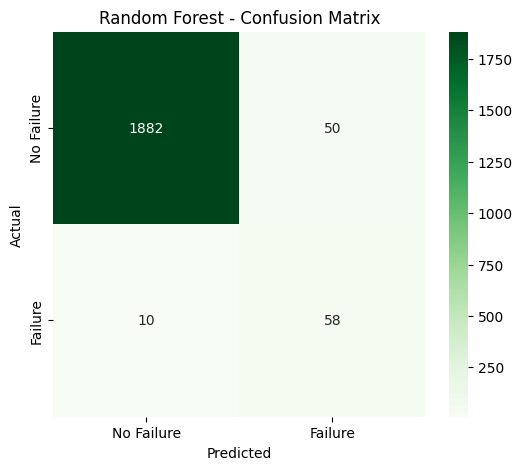

In [122]:
# Evaluate Random Forest Model
y_pred_rf = rf_model.predict(X_test_scaled_fe)

print("=" * 60)
print("🌲 RANDOM FOREST RESULTS")
print("=" * 60)
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_rf, annot=True, fmt='d', cmap='Greens',
    xticklabels=['No Failure', 'Failure'],
    yticklabels=['No Failure', 'Failure']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest - Confusion Matrix')
plt.show()

In [123]:
# Train XGBoost Model
from xgboost import XGBClassifier

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train_balanced, y_train_balanced)
print("✅ XGBoost Model Trained")

✅ XGBoost Model Trained


🚀 XGBOOST RESULTS
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1932
           1       0.43      0.87      0.57        68

    accuracy                           0.96      2000
   macro avg       0.71      0.91      0.77      2000
weighted avg       0.98      0.96      0.96      2000



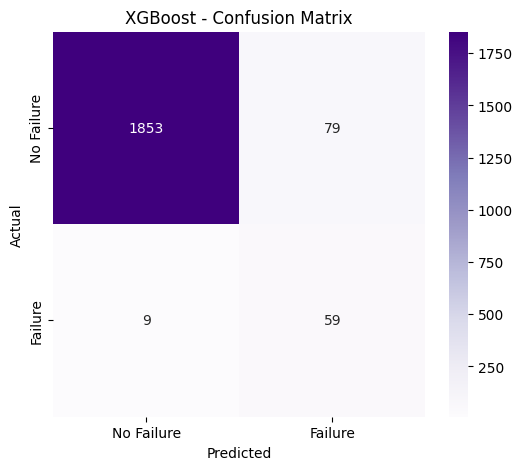

In [124]:
# Evaluate XGBoost Model
y_pred_xgb = xgb_model.predict(X_test_scaled_fe)

print("=" * 60)
print("🚀 XGBOOST RESULTS")
print("=" * 60)
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_xgb, annot=True, fmt='d', cmap='Purples',
    xticklabels=['No Failure', 'Failure'],
    yticklabels=['No Failure', 'Failure']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost - Confusion Matrix')
plt.show()

In [125]:
# Model Comparison
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

models_comparison = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Precision (Failure)': [
        precision_score(y_test, y_pred, pos_label=1),
        precision_score(y_test, y_pred_rf, pos_label=1),
        precision_score(y_test, y_pred_xgb, pos_label=1)
    ],
    'Recall (Failure)': [
        recall_score(y_test, y_pred, pos_label=1),
        recall_score(y_test, y_pred_rf, pos_label=1),
        recall_score(y_test, y_pred_xgb, pos_label=1)
    ],
    'F1-Score (Failure)': [
        f1_score(y_test, y_pred, pos_label=1),
        f1_score(y_test, y_pred_rf, pos_label=1),
        f1_score(y_test, y_pred_xgb, pos_label=1)
    ]
}

comparison_df = pd.DataFrame(models_comparison)
print("\n" + "=" * 70)
print("📊 MODEL COMPARISON SUMMARY")
print("=" * 70)
print(comparison_df.to_string(index=False))
print("=" * 70)


📊 MODEL COMPARISON SUMMARY
              Model  Precision (Failure)  Recall (Failure)  F1-Score (Failure)
Logistic Regression             0.141772          0.823529            0.241901
      Random Forest             0.537037          0.852941            0.659091
            XGBoost             0.427536          0.867647            0.572816



🔝 Top 10 Most Important Features (Random Forest):
                Feature  Importance
 Rotational speed [rpm]    0.208608
            Torque [Nm]    0.186505
                  Power    0.178743
        Tool wear [min]    0.126401
Torque_Tool_Interaction    0.115178
              Temp_Diff    0.097077
    Air temperature [K]    0.043785
Process temperature [K]    0.028840
                 Type_L    0.007739
                 Type_M    0.007124


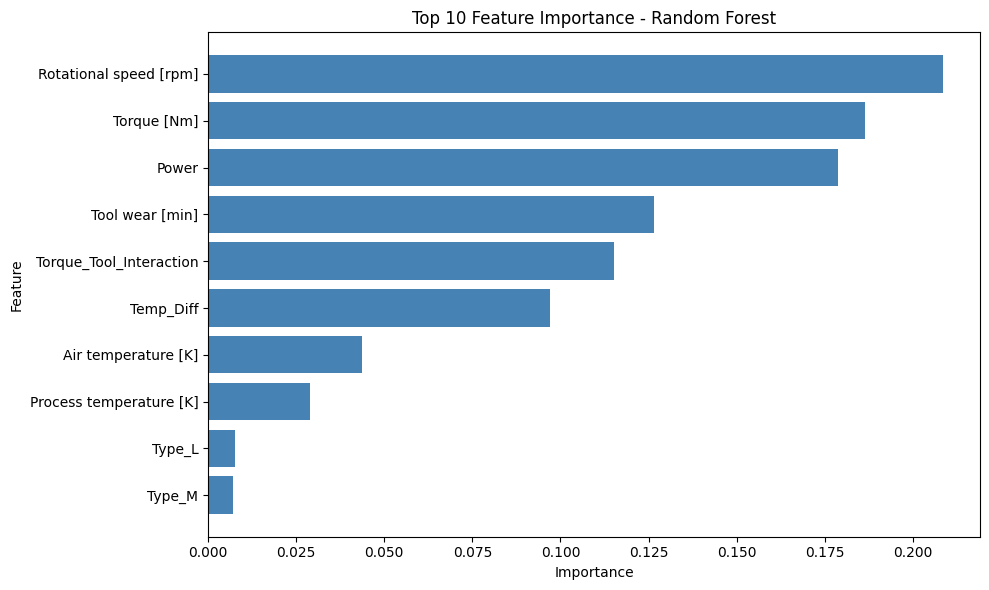

In [126]:
# Feature Importance (for best model)
feature_names = X_train_fe.columns

# Get feature importance from Random Forest
importances_rf = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_rf
}).sort_values('Importance', ascending=False)

print("\n🔝 Top 10 Most Important Features (Random Forest):")
print(feature_importance_df.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance_df.head(10)
plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [127]:
import joblib  

# Save the best model
best_model = rf_model
best_model_name = "Random Forest"

joblib.dump(best_model, 'models/machine_failure_model.pkl')
joblib.dump(scaler_fe, 'models/scaler.pkl')

print(f"\n✅ Best Model ({best_model_name}) and Scaler saved successfully!")
print(f"📁 Saved to: models/machine_failure_model.pkl")


✅ Best Model (Random Forest) and Scaler saved successfully!
📁 Saved to: models/machine_failure_model.pkl
